In [1]:
import pandas as pd

df = pd.read_csv('datasets/credit_train_preprocessed.csv')
df

,Loan Status,Current Loan Amount,Term,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Current Credit Balance,Credit Score Class
0,Fully Paid,139004.918823,Short Term,2559110.0,2,Rent,Debt Consolidation,18660.28,22.6,33.0,4.0,437171.0,2
1,Charged Off,68286.145159,Long Term,1133274.0,8,Rent,Debt Consolidation,9632.81,17.4,53.0,4.0,60287.0,2
2,Fully Paid,113562.548736,Long Term,1722654.0,3,Rent,Buy House,15647.45,22.3,30.0,7.0,107559.0,2
3,Fully Paid,108585.569794,Short Term,1454507.0,8,Home Mortgage,Debt Consolidation,13090.43,28.8,21.0,14.0,193990.0,2
4,Charged Off,181661.859799,Long Term,1494616.0,0,Rent,Debt Consolidation,14697.07,16.6,50.0,8.0,343995.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18177,Fully Paid,-928.116652,Short Term,855038.0,10,Home Mortgage,Buy a Car,6583.69,16.5,28.0,4.0,9861.0,2
18178,Fully Paid,23909.762065,Short Term,1297947.0,4,Own Home,Debt Consolidation,9453.26,15.9,15.0,12.0,123880.0,3
18179,Fully Paid,45563.986235,Short Term,2272514.0,2,Rent,Debt Consolidation,24808.30,20.8,18.0,6.0,96273.0,2
18180,Fully Paid,72383.253330,Short Term,1141824.0,10,Rent,Debt Consolidation,13321.28,18.8,32.0,3.0,55119.0,2


In [2]:
X = df.drop(columns=['Credit Score Class'], axis=1)
y = df['Credit Score Class']

In [3]:
X.dtypes

Loan Status                      object
Current Loan Amount             float64
Term                             object
Annual Income                   float64
Years in current job              int64
Home Ownership                   object
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts         float64
Current Credit Balance          float64
dtype: object

In [4]:
X.isnull().sum()

Loan Status                     0
Current Loan Amount             0
Term                            0
Annual Income                   0
Years in current job            0
Home Ownership                  0
Purpose                         0
Monthly Debt                    0
Years of Credit History         0
Months since last delinquent    0
Number of Open Accounts         0
Current Credit Balance          0
dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

les = {}
for col in X.select_dtypes(exclude='number').columns:
    if col in les:
        le = les[col]
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        X[col] = X[col].apply(lambda x: le_dict.get(x, -1))
    else:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        les[col] = le

In [6]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [20, 50, 100, 150, 200],
    'random_state': [42]
}


from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [20, 50, 100, 150, 200],
                         'random_state': [42]},
             scoring='accuracy')

In [7]:
# Interpret the results
pd.concat([pd.DataFrame(grid.cv_results_["params"]), pd.DataFrame({"score": grid.cv_results_["mean_test_score"]})], axis=1).sort_values(by="score", ascending=False).sort_values(by="score", ascending=False)

,criterion,n_estimators,random_state,score
4,gini,200,42,0.729458
14,log_loss,200,42,0.729238
9,entropy,200,42,0.729238
8,entropy,150,42,0.728633
13,log_loss,150,42,0.728633
3,gini,150,42,0.728193
2,gini,100,42,0.728028
12,log_loss,100,42,0.727533
7,entropy,100,42,0.727533
1,gini,50,42,0.726873


In [8]:
rf = grid.best_estimator_
feature_importances = rf.feature_importances_

# Display feature importances
fi = pd.DataFrame(zip(X.columns, feature_importances), columns=['feature', 'importance']).sort_values(by="importance", ascending=False)
fi

,feature,importance
1,Current Loan Amount,0.136994
3,Annual Income,0.136379
11,Current Credit Balance,0.124797
7,Monthly Debt,0.124546
8,Years of Credit History,0.117501
9,Months since last delinquent,0.106644
10,Number of Open Accounts,0.080719
4,Years in current job,0.058004
2,Term,0.046166
6,Purpose,0.034112


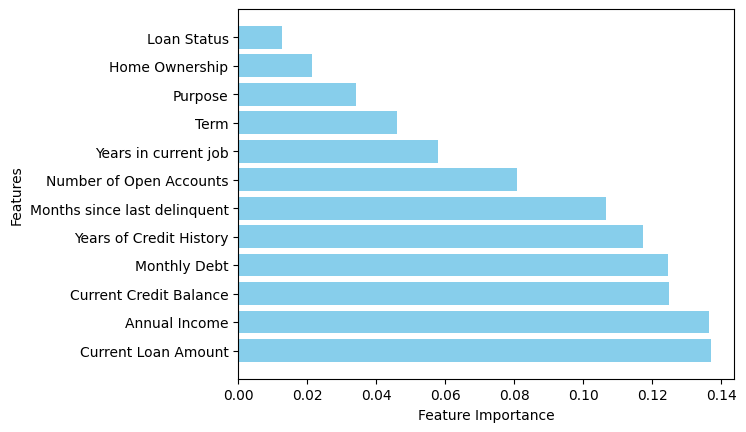

In [9]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.barh(fi['feature'], fi['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()